#  <center> Taller  de Aprendizaje Automático </center>
##  <center> Taller 3: Demanda de bicicletas compartidas  </center>

# Introducción

En esta actividad se trabajará sobre el *dataset* de la competencia [*Bike Sharing Demand*](https://www.kaggle.com/c/bike-sharing-demand) de *Kaggle*. El objetivo de la competencia, predecir la demanda de bicicletas a partir de la combinación de datos históricos sobre demanda y clima. 

El conjunto corresponde a datos de alquiler por hora y abarcan dos años de información. El subconjunto de *train* está compuesto por los primeros 19 días de cada mes, mientras que el subconjunto de *test* va desde 20 hasta el final del mes. Este último debe ser utilizado solamente en la parte 10 para subir los resultados a la página de la competencia.

En esta actividad nos centraremos en el algoritmo **Decision Trees**, el cual al igual que *SVM* es un algoritmo versatil que se utiliza en problemas tanto de clasificación como de regresión. También trabajaremos con algoritmos basados en métodos de ensamble de estimadores, como son **Random Forest** y **Gradient Boosting**, que utilizan como estimador base **Decision Trees**.


## Objetivos


*   Conocer los estimadores *Decision Trees*, entender cómo funcionan para un problema de regresión, ver ventajas y desventajas.
*   Familiarizarse con los métodos de ensamblado de estimadores y entender cual es el objetivo de usar estos métodos.
*   Incorporar una función de transformación de columnas y una función de medida de desempeño personalizadas.


## Formas de trabajo

#### Opción 1: Trabajar localmente

##### Descarga de datos disponibles en Kaggle

Luego, para descargar el dataset de IMDb reviews:

In [2]:
!kaggle competitions download -c bike-sharing-demand


  0%|          | 0.00/189k [00:00<?, ?B/s]
100%|##########| 189k/189k [00:00<00:00, 2.37MB/s]


Descomprima el archivo descargado:

In [3]:
import shutil
shutil.unpack_archive('./bike-sharing-demand.zip', './')

#### Opción 2:  Trabajar en *Colab*. 

Se puede trabajar en Google Colab. Para ello es necesario contar con una cuenta de **google drive** y ejecutar un notebook almacenado en dicha cuenta. De lo contrario, no se conservarán los cambios realizados en la sesión. En caso de ya contar con una cuenta, se puede abrir el notebook y luego ir a `Archivo-->Guardar una copia en drive`. 

La siguiente celda monta el disco personal del drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A continuación, vaya a su cuenta de [Kaggle](https://www.kaggle.com/) (o cree una si aún no lo ha hecho), haga clic en el icono de perfil en la esquina superior derecha de la pantalla y seleccione "Your Account" en la lista desplegable. Luego, seleccione la viñeta "Account" y haga clic en "Create new API token". Entonces un archivo llamado kaggle.json se descargará automáticamente a su carpeta de descargas. Este archivo contiene sus credenciales de inicio de sesión para permitirle acceder a la API.

La siguiente celda realiza la configuración necesaria para obtener datos desde la plataforma Kaggle. Le solicitará que suba el archivo kaggle.json descargado anteriormente.

In [2]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


Una vez guardado el *token* se pueden descargar los datos, en este caso se bajarán los datos del dataset IMDb reviews:

In [3]:
!kaggle competitions download -c bike-sharing-demand

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.92MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 53.3MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 28.8MB/s]


In [ ]:
!unzip bike-sharing-demand.zip

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TAA-fing/TAA-2022/blob/main/talleres/taller3_demanda_de_bicicletas.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
</table>

## Paquetes a utilizar y Carga de Datos

En esta actividad se utilizarán algunas bibliotecas auxiliares que deberán ser instaladas. Ejecutar la siguiente celda hasta que se ejecute sin errores. En caso de error, se puede instalar el paquete faltante desde el notebook con el comando:

`!pip install paquete_faltante`

In [2]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### (Opcional) librería de visualización de datos
#import seaborn as sns
#sns.set_theme(style="whitegrid")

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sampleSubmission.csv')

## Parte 1 - Análisis de los datos

#### Objetivos

 - Analizar el conjunto de datos con las diferentes funciones de *pandas* que crea pertinente.

#### Preguntas:

 - ¿Qué efecto tiene el tiempo (meteorológico) sobre el alquiler de bicicletas? ¿Es el mismo para clientes registrados y casuales? ¿Coincide esto con lo que asumiría a priori?
 
 - Habiendo observado lo anterior, ¿A qué se puede deber que la correlación entre *season* y *casual* sea baja?
 
 - Vamos a trabajar con las codifificaciones por defecto (salvo datetime que veremos en la Parte 2). ¿Le parece adecuado?

## Parte 2 - Características temporales

La primer columna de los datos (*datetime*) corresponde a las marcas de tiempo asociadas a cada instancia. Para que estos tengan el orden cronológico que representan es necesario pasarlos de tipo *string* a tipo *datetime*. Para esto *Pandas* proporciona la función *to_datetime()*. Correr la siguiente celda para hacer el cambio.

In [3]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

##### La figura siguiente muestra cómo varía la cantidad de bicicletas alquiladas en función del tiempo. 

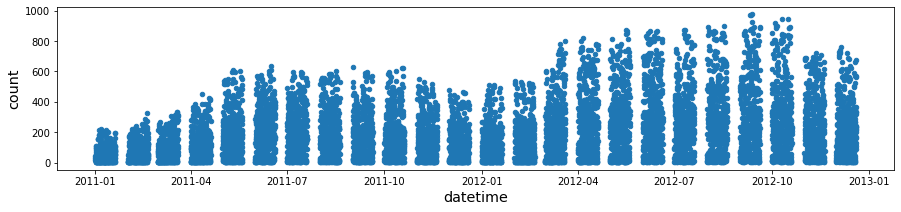

In [4]:
df_train.plot(x='datetime', y='count', figsize=[15,3],kind='scatter',color='tab:blue')
plt.xlabel('datetime',fontsize='x-large')
plt.ylabel('count',fontsize='x-large')
plt.show()

#### Preguntas:

- ¿Le parece razonable la division en conjuntos de train y test que se tomó en el desafío?
- ¿Cómo varían temporalmente (día, semana, mes, año) los alquileres?

El tipo de dato *datetime* permite extraer de forma sencilla datos categóricos como la hora, el día de la semana, entre otros. La siguiente celda agrega a los datos de *train* estas nuevas características.

In [5]:
df_train['hour'] = df_train['datetime'].dt.hour
df_train['weekday'] = df_train['datetime'].dt.weekday

#### Ejercicio:

 - Grafique count, registered y casual en función de las horas y el día de la semana. ([*Sugerencia:*](https://seaborn.pydata.org/generated/seaborn.barplot.html) Ejemplos de la librería *seaborn*)

##### A partir de las gráficas responder las siguientes preguntas:

 - ¿Cómo explicaría la diferencia entre las distribuciones de los clientes registrados y casuales? 
 - ¿Qué desventaja le encuentra a utilizar un regresor lineal para predecir los alquileres a partir de la hora del día?¿Cómo transformaría esta característica para paliar este problema? 
 - ¿Es necesaria esta transformación cuando se utilizan Árboles de Decisión?

#### Selección de Características:

*   Entre el día, el mes y el año ¿cuáles de estos datos les pareces agregar como nuevas características y cuáles no? y ¿Por qué?
*   Agregar las características seleccionadas.

## Parte 3 - Preparación de los datos y Métrica de evaluación

Previo a trabajar con los estimadores:

*   Apartar la columna objetivo y eliminarla del conjunto de entrenamiento. 
*   Eliminar las columnas *'casual'* y *'registered'*. ¿Por qué esto es necesario?.
*   Eliminar la columna *'datetime'*.

Durante la actividad los estimadores deben ser evaluados con la misma medida de desempeño utilizada en la competencia: 

Root Mean Squared Logarithmic Error (RMSLE)
$$\sqrt{\frac{1}{n}\sum_{i}^{n}\big(\log(y_{i} + 1) - \log(\hat{y}_{i} + 1)\big)^2}$$

Este tipo de medida se utiliza cuando los valores a estimar son grandes. La librería *Scikit-Learn* incluye la función de desempeño [*mean_squared_log_error*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE), esta función se puede utilizar  para la validación ya que alcanza las mismas soluciones que su raíz (RMSLE). De igual forma los resultados se deben mostrar con RMSLE.

## Parte 4 - Decision Trees

#### Objetivos

*   Importar la función *DecisionTreeRegressor()* de *Scikit-Learn*. 
*   Aplicar validación cruzada a un estimador con los hiper-parámetros por defecto.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Para lo último utilizar la función *fill_between()* de *matplotlib*. 

#### Preguntas:

*   ¿Qué fenómeno se logra apreciar en el gráfico? ¿A qué se debe? ¿Por qué esto es un problema?
*   Indicar y describir alguno de los hiper-parámetros que la función *DecisionTreeRegressor()* ofrece para limitar la complejidad del estimador.

#### Ejemplo Lack of smoothness

Como ejemplo se tomará la siguiente situación:

 - Domingo 
 - Despejado o Parcialmente nublado
 - A las 15 horas 
 - En primavera 
 
Se observará el efecto de la sensación térmica en la predicción de alquileres de bicicletas.

 - ¿Cómo espera que sea dicho efecto en un rango de 10°C a 30°C?

In [353]:
index = 2345
X_prueba = df_train.iloc[index:index+1]
X_prueba

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,year
2345,2,0,0,1,28.7,25.0,54,0.0,15,6,6,2011


In [354]:
X_prueba = pd.concat([X_prueba]*21,ignore_index=True)

index = 0
for k in np.linspace(10,29,20):
    X_prueba.loc[index,'atemp']= k
    index += 1

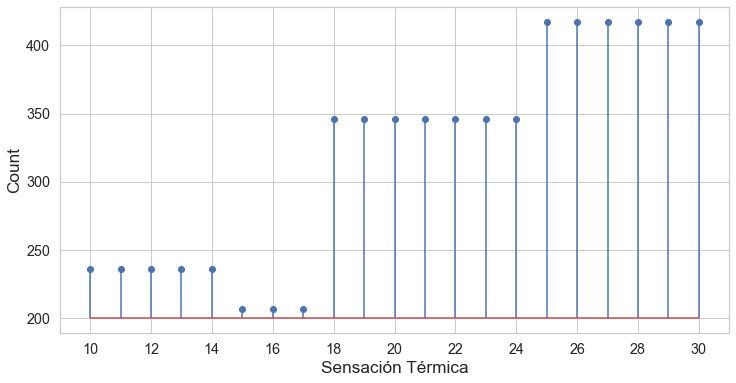

In [355]:
regressor.fit(df_train,y_train)

plt.figure(figsize=(12,6))
plt.stem(np.linspace(10,30,21),regressor.predict(X_prueba),bottom=200)
plt.xlabel('Sensación Térmica',fontsize='x-large')
plt.ylabel('Count',fontsize='x-large')
plt.xticks(np.linspace(10,30,11),fontsize='large')
plt.yticks(fontsize='large')
plt.show()

 - Observe el cambio que genera la sensación térmica a la salida (en particular el pasar de una sensación térmica de 24°C a 25°C). (incremento del 20%)
 
 - ¿Qué desventaja le encuenta a los árboles de decisión en comparación con modelos lineales?

### Ajuste Fino

#### Objetivos

*   Seleccionar uno de los hiper-parámetros y encontrar el mejor estimador.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los resultados anteriores.
*   Graficar cómo varían los valores de RMSLE de entrenamiento y validación, para diferentes valores del hiper-parámetro.
*   Mostrar el mejor valor RMSLE (promedio de todos los *folds*) y el valor del hiper-parámetro.
*   Visualizar el árbol hasta los nodos de profundidad 2 utilizando la función *plot_tree()*. Agrandar el tamaño de la imagen de manera de poder leer la descripción de cada nodo.
*   Analizar las decisiones que está tomando el árbol para los primeros nodos.
*   Graficar los primeros 200 valores objetivo junto con sus predicciones.

## Parte 5 - Random Forest

#### Preguntas sobre métodos de Ensamble:

*   ¿Cuáles son las ventajes de los métodos de Ensamble?
*   ¿A qué métodos de ensamble está asociado *Random Forest*?.
*   Importar la función *RandomForestRegressor()* de *Scikit-Learn*.
*   Indicar y describir los principales hiper-parámetros correspondientes a los métodos de ensamble que ofrece la función.




#### Ajuste fino



*   Encontrar el mejor estimador para *Random Forest* usando como estimador base el encontrado en la parte 4.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los resultados correspondientes de la parte 4.
*   Mostrar el mejor valor de RMSLE (promedio de todos los folds) y compararlo con el de la parte 4. Mostrar los valores seleccionados de los hiper-parámetros.
*   ¿Qué ventaja se pierde con repecto a usar un sólo árbol?
*   Graficar los primeros 200 valores objetivo junto con sus predicciones. Comparar con el gráfico correspondiente de la parte 4.
*   Mostrar la importancia de cada característica utilizando la variable *feature_importances_*.



## Parte 6 - Gradient Boosting

#### XGBoost

*   Indicar cuál es la principal diferencia entre *Bagging* y *Boosting*.
*   Importar la función *XGBRegressor()* de la librería [*xgboost*](https://github.com/dmlc/xgboost).
*   Este estimador a diferencia de los anteriores puede devolver predicciones negativas para estos datos. Indicar en que caso se pueda dar esto y por qué esto no sucedía con los estimadores anteriores.
*   Las predicciones negativas no pueden ser evaluadas por RMSLE. Por lo tanto, crear una nueva función de evaluación que fuerce a cero todos los valores negativos de las predicciones y luego calcule el valor de RMSLE. Para esto se debe utilizar la función *make_score* de *Sickit-Learn*, para que la nueva función pueda ser utilizada en las funciones de selección de modelos.


**Nota:** *Scikit-Learn* también ofrece una implementación de *Gradient Boosting*, pero *XGBRegressor()* es la implementación de [*eXtreme Gradient Boosting*](https://arxiv.org/pdf/1603.02754.pdf?__hstc=133736337.1bb630f9cde2cb5f07430159d50a3c91.1513641600097.1513641600098.1513641600099.1&__hssc=133736337.1.1513641600100&__hsfp=528229161) un variante del algoritmo tradicional que dentro de algunas ventajas requiere menos tiempo de entrenamiento. La implementación de las funciones de la libreía son muy similares a las de *Scikit-Learn*, de igual forma aquí le dejamos un [ejemplo](https://www.kaggle.com/alexisbcook/xgboost) de cómo usarla. 







#### Ajuste fino



*   Encontrar el mejor estimador para *Gradient Boosting* usando como estimador base el encontrado en la parte 4.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los gráficos correspondientes.
*   Mostrar el mejor valor de RMSLE (promedio de todos los folds) y compararlo con los anteriores. Mostrar los valores seleccionados de los hiper-parámetros.
*   Graficar los primeros 200 valores objetivo junto con sus predicciones. Comparar con los gráficos corespondientes.
*   ¿Qué compromiso hay entre los hiper-parámetros *n_estimators* y *learning_rate*?



## Parte 7 - Custom Transformers 

- Construir un *Custom Transformer* que extraiga las caracterísicas temporales, siguiendo el ejemplo del capítulo 2 del libro.

## Parte 8 - Generar un modelo

#### Objetivos:

 - Generar el mejor modelo posible. Se podrá explorar posibles mejoras en cualquiera de las siguientes etapas:

    - Parámetros óptimos del regresor.
    - Predicción del logarítmo de alquileres. (Puede resultar útil la función `TransformedTargetRegressor` de *sklearn*).
    - Predicción de alquileres registered y casual por separado.
    - Separación de conjunto de Entrenamiento y Validación tomando en cuenta la generación del conjunto de Test del desafío.

## Parte 9 - Submit
Construir un *pipeline* para el estimador que consideren que tuvo mejor desempeño. El pre-procesamiento debe incluir la extracción de las nuevas características.

Subir los resultados del *pipeline* para los datos de *test*,  a la [página](https://www.kaggle.com/c/bike-sharing-demand/submit) de la competencia.



*   ¿Cuánto fue el valor de RMSLE para el conjunto de test?


## Parte 10 - Proyecto

#### Objetivos:

 - Probar clasificar los datos del proyecto con los distintos métodos vistos en este taller (Árboles de Decisión, Random Forest, XGBoost).